# Burst mode simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from ipywidgets import interact, interact_manual
import ipywidgets as widgets

## Oscillator and RA parameters
Gain medium energy saturation

In [2]:
energy_saturation = 2.0e-3 # [J]

Gain medium fluorescence lifetime

In [3]:
tau = 500e-9 # [s]

Pulse wavelength

In [4]:
wl = 1064e-9 # [m]

Gain

In [5]:
G0 = 2.0e0 # []

Pulse energy

In [6]:
energy_0 = 75.0e-9 # [J]

Cavity lengths of the regenerative amplifier and oscillator

In [7]:
T_RA = 15.8e-9 # [s]
T_osc = 15.6e-9 # [s]

Saturation power
$$P = \frac{E_{saturation}}{\tau}\times\log G_0$$

In [8]:
P  = energy_saturation / tau * np.log(G0)

## Control parameters
Number of pulses per burst

In [9]:
N=10

Injection, trapping and extraction periods

In [10]:
# injection period
T1 = (N+0.5) * T_osc

# trapping/amplification period
T2 = 3.0 * T_RA

# extraction period
T3 = 20.0 * T_osc

Losses at passive elements (mirrors, waveplates)

In [11]:
losses_passive = 0.05

Output of the regenerative amplifier

In [26]:
def RA_output (losses_injection, losses_extraction, N, T2, T3):
    T1 = (N+0.5)*T_osc
    
    pulses = int(np.floor((T1) / T_osc))

    burst_pulses = range(pulses)

    interactions = []

    for i in range(pulses):
        for time in np.arange(i*T_osc, T1+T2+T3, T_RA):
            interactions = interactions + [(time, i)]

    interactions = sorted(interactions, key = lambda time: time[0])

    # first stage
    energy = [energy_0 * losses_passive] * pulses
    energy_stored0 = energy_saturation * np.log(G0)
    time_previous = 0

    RA = {}
    RA['time'] = []
    RA['energy_stored'] = []
    RA['pulse_energy'] = []

    out = {}
    out['time'] = []
    out['energy'] = []
    
    for i, (time, pulse) in list(enumerate(interactions)):
        
        T = time - time_previous

        #energy, stored at gain medium decreases due to spontaneous emission, increases by pumping
        energy_stored =  energy_stored0 * np.exp(-T/tau) + P * tau * (1.0 - np.exp (-T/tau))

        #losses before amplifiers
        energy[pulse] = energy[pulse] * (1.0 - losses_passive)

        # first interval - losses at leaking PBS2
        if time <= T1:
            #losses  at the end of cavity
            energy[pulse] = energy[pulse] * (1.0 - losses_injection(time))

        for _ in range(2):
            #pulse enters gain medium    
            energy_in = energy[pulse]

            #pulse exits gain medium
            energy_out = energy_saturation * np.log (1.0 + (np.exp(energy_in/energy_saturation) - 1.0) * np.exp (energy_stored/energy_saturation))

            #energy, stored at gain medium, decreases
            energy_stored = energy_stored - (energy_out - energy_in)

            #energy, stored at gain medium, for next interaction
            energy_stored0 = energy_stored

            energy[pulse] = energy_out


        # third interval - losses at PBS2, output generation
        if time > T1+T2:
            out['time'].append(time)
            out['energy'].append(energy[pulse] * losses_extraction (time-T1-T2))

            #losses at leaking PBS2
            energy[pulse] = energy[pulse] * (1.0 - losses_extraction (time-T1-T2))

        time_previous = time

        RA['time'].append(time)
        RA['energy_stored'].append(energy_stored)
        RA['pulse_energy'].append(energy[pulse])

    return (RA, out)

In [41]:
def calculate_burst (_losses_injection, _losses_extraction, _N, _N_T2, _N_T3):
    losses_injection = lambda x: 1-_losses_injection
    losses_extraction = lambda x: 1-_losses_extraction
    T1 = (_N+0.5)*T_osc
    T2 = _N_T2 * T_RA
    T3 = _N_T3 * T_osc
        
    RA, out = RA_output(losses_injection, losses_extraction, _N, T2, T3)
    gs = gridspec.GridSpec (1, 2, wspace=0.5)

    plt.figure('Burst generation', figsize=(15,6))
    plt.clf()
    plt.subplots_adjust(right=0.83)

    ax1 = plt.subplot (gs[0,0])
    ax12 = ax1.twinx()
    ax13 = ax1.twinx()


    p1, = ax1.plot(np.array(RA['time'])*1.0e9, np.array(RA['energy_stored'])*1.0e3, '.-', label='Gain energy')
    p2, = ax12.plot(np.array([0, T1, T1, T1+T2, T1+T2, T1+T2+T3])*1.0e9, 
                    np.array([1-losses_injection(0)]+[1.0-losses_injection(T1)]+[1.0]*2+[1-losses_extraction(T2+T3)]*2), color='red', label='PC voltage (arbitrary)')
    p3 = ax13.stem(np.array(out['time'])*1e9, np.array(out['energy'])*1e6, 'g', markerfmt='go')

    ax1.set_xlim([0, (T1+T2+T3)*1.0e9])
    #ax1.set_xticklabels([])
    ax1.set_ylabel('Energy at gain, mJ')



    ax12.set_ylabel('PC voltage, a.u.')
    ax12.set_ylim([0, 1.2])
    ax1.set_xlabel ('Time, ns')


    ax13.set_ylabel('Output pulse energy, uJ')
    #ax13.spines['left'].set_position(700)
    ax13.spines['right'].set_position(('axes', 1.15))


    ax1.set_title("Burst generation, N={:d} pulses".format(N))


    ax1.yaxis.label.set_color(p1.get_color())
    ax12.yaxis.label.set_color(p2.get_color())
    ax13.yaxis.label.set_color('green')


    #ax13.yaxis.label.set_color(p3.get_color())

    ax1.tick_params(axis='y', colors=p1.get_color())
    ax12.tick_params(axis='y', colors=p2.get_color())
    ax13.tick_params(axis='y', colors='green')

    ax3 = plt.subplot (gs[0,1])
    ax3.stem(np.array(out['time'])*1e9, np.array(out['energy'])*1e6, 'g', markerfmt='go')

    ax3.set_title("Output")
    ax3.set_xlabel("Time, ns")
    ax3.set_ylabel('Output pulse energy, uJ')

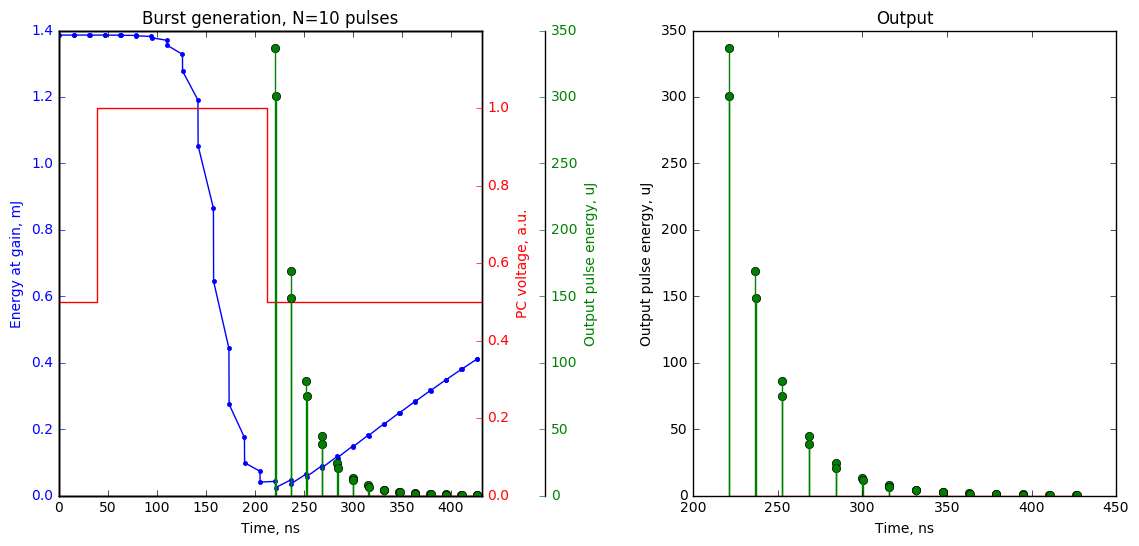

In [43]:
%matplotlib inline
interact(calculate_burst, 
         _losses_injection=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, continuous_update=False, description="PC during injection"),
        _losses_extraction=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, continuous_update=False, description="PC during extraction"),
        _N=widgets.IntSlider(min=1, max=10, step=1, value=1, continuous_update=False, description="Number of pulses in burst"),
        _N_T2=widgets.FloatSlider(min=0.0, max=20.0, step=0.5, value=3.0, continuous_update=False, description="Amplification round-trips in RA"),
        _N_T3=widgets.FloatSlider(min=1.0, max=20.0, step=0.5, value=20.0, continuous_update=False, description="Extraction time (in osc lengths)")
        )